# Undirected Wiring Diagrams

To specify complex systems, you need to specify primitive models and a pattern of composition.
This example shows you how to use Undirected Wiring Diagrams (UWDs) as a language for expressing patterns of composition.
These diagrams are undirected, because they do not have inputs and outputs. UWDs are for systems that compose by sharing variables.
They are not for systems that compose like functions, where output of a system is passed as input to another system.
For systems that compose like functions, use Directed Wiring Diagrams.

In [1]:
using ..SyntacticModels
using ..SyntacticModels.SyntacticModelsBase
using ..SyntacticModels.AMR
using ..SyntacticModels.ASKEMUWDs

using Test
using JSON3
using Catlab.RelationalPrograms
using Catlab.WiringDiagrams
using Catlab.Graphics

draw(uwd) = to_graphviz(uwd, box_labels=:name, junction_labels=:variable)

draw (generic function with 1 method)

This example follows what in current catlab would be given as:

```julia
@relation (x:X, z:Z) where y:Y begin
  R(x,y)
  S(y,z)
  T(z,y,u)
end
```

Eventually, we will update the `@relation` macro to use this ADT based representation.
This will allow users to create syntactic UWDExprs from with an easy to write syntax embedded in Julia.

In [2]:
v1 = Typed(:x, :X)
v2 = Typed(:y, :Y)
v3 = Typed(:z, :Z)
v4 = Untyped(:u)
c = [v1, v3]
s = [Statement(:R, [v1,v2]),
  Statement(:S, [v2,v3]),
  Statement(:T, [v3,v2, v4])]
u = UWDExpr(c, s)

{ R(x:X, y:Y)
  S(y:Y, z:Z)
  T(z:Z, y:Y, u) } where {x:X, z:Z}

We can test that if we write the `UWDExpr` into a JSON string, then we get the same information when we read it.
The `==` operator for MLStyle types is not correctly working for these types, I think because some type information is being lost.

In [3]:
s = JSON3.write(u)
ujson = JSON3.read(s, UWDTerm)
@test s == JSON3.write(ujson)

Test Passed

The element type of the array changes when you go through JSON, even though type of the elements are the same.

In [4]:
typeof(ujson.statements), typeof(u.statements)

(Vector{SyntacticModels.ASKEMUWDs.Statement}, Vector{SyntacticModels.ASKEMUWDs.Statement})

One can construct a Catlab Relation diagram from this expression.

In [5]:
uwd = ASKEMUWDs.construct(RelationDiagram, u)

Catlab.Programs.RelationalPrograms.TypedUnnamedRelationDiagram{Symbol, Symbol, Symbol} {Box:3, Port:7, OuterPort:2, Junction:4, Type:0, Name:0, VarName:0}
┌─────┬──────┐
│ Box │ name │
├─────┼──────┤
│   1 │    R │
│   2 │    S │
│   3 │    T │
└─────┴──────┘
┌──────┬─────┬──────────┬───────────┐
│ Port │ box │ junction │ port_type │
├──────┼─────┼──────────┼───────────┤
│    1 │   1 │        1 │         X │
│    2 │   1 │        3 │         Y │
│    3 │   2 │        3 │         Y │
│    4 │   2 │        2 │         Z │
│    5 │   3 │        2 │         Z │
│    6 │   3 │        3 │         Y │
│    7 │   3 │        4 │   untyped │
└──────┴─────┴──────────┴───────────┘
┌───────────┬────────────────┬─────────────────┐
│ OuterPort │ outer_junction │ outer_port_type │
├───────────┼────────────────┼─────────────────┤
│         1 │              1 │               x │
│         2 │              2 │               z │
└───────────┴────────────────┴─────────────────┘
┌──────────┬───────────────┬──────────┐
│ Junction │ junction_type │ variable │
├──────────┼───────────────┼──────────┤
│        1 │             X │        x │
│        2 │             Z │        z │
│        3 │             Y │        y │
│        4 │       untyped │        u │
└──────────┴───────────────┴──────────┘

And then use Graphviz to draw the uwd.

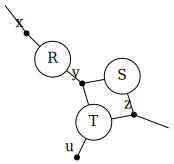

In [6]:
draw(uwd)

## Model Headers

As usual, we can add an AMR header to a UWD Model:

In [7]:
h = AMR.Header("rst_relation", "modelreps.io/UWD", "A demo UWD showing generic relation composition", "UWDExpr", "v0.1")
mexpr = UWDModel(h, u)

"""
ASKE Model Representation: rst_relationv0.1 :: UWDExpr 
   modelreps.io/UWD

A demo UWD showing generic relation composition
"""
UWD:
{ R(x:X, y:Y)
  S(y:Y, z:Z)
  T(z:Z, y:Y, u) } where {x:X, z:Z}

And write that model in JSON

In [8]:
s = JSON3.write(mexpr)

"{\"uwd\":{\"statements\":[{\"variables\":[{\"var\":\"x\",\"type\":\"X\",\"_type\":\"Typed\"},{\"var\":\"y\",\"type\":\"Y\",\"_type\":\"Typed\"}],\"_type\":\"Statement\",\"relation\":\"R\"},{\"variables\":[{\"var\":\"y\",\"type\":\"Y\",\"_type\":\"Typed\"},{\"var\":\"z\",\"type\":\"Z\",\"_type\":\"Typed\"}],\"_type\":\"Statement\",\"relati" ⋯ 216 bytes ⋯ "\"},{\"var\":\"z\",\"type\":\"Z\",\"_type\":\"Typed\"}],\"_type\":\"UWDExpr\"},\"header\":{\"description\":\"A demo UWD showing generic relation composition\",\"name\":\"rst_relation\",\"_type\":\"Header\",\"model_version\":\"v0.1\",\"schema\":\"modelreps.io/UWD\",\"schema_name\":\"UWDExpr\"},\"_type\":\"UWDModel\"}"

Just as check, the headers should be preserved.

In [9]:
@test JSON3.write(JSON3.read(s, UWDModel)) == JSON3.write(mexpr)

Test Passed